In [1]:
# Figure 2: find example of gene that has credible
# novel isoforms  relatively highly expressed
# (maybe that also has high entropy)

# other things that would be interesting 
# involved in DTU
# population-specific
# novel exon


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [4]:
def get_melted_pi_counts_table(ver='poder', min_t_cpm=None):
    assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
    meta = load_meta()
    meta = meta.loc[meta.merged_run_mode==True]
    sample_d = dict([(entry.cell_line_id, entry['sample']) \
                     for ind, entry in meta.iterrows()])
    
    
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    df = pd.read_csv(f, sep='\t')
    df.head()
    df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
    df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
    df.rename(sample_d, axis=1, inplace=True)

    
    id_vars = ['tid']
    sample_columns = list(set(df.columns)-set(id_vars))
    tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='t_tpm')
    tpm_df = tpm_df.merge(meta[['sample', 'population']],
                          how='left', on='sample')
    tpm_df.head()
    
    if ver == 'poder':
        f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
    elif ver == 'v47':
        f = '../data/analysis/04_relative_abundances_allgenes_gencode.tsv'
    df = pd.read_csv(f, sep='\t')
    df.sort_values(by='geneid.v').head()
    df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)
    id_vars = ['tid', 'gid']
    sample_columns = list(set(df.columns)-set(id_vars))
    df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='pi')

    
    # filter based on min. cpm
    df = df.merge(tpm_df, how='left',
                  on=['tid', 'sample'])
    
    
    # add gene expression
    ver = 'poder'
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['gene_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['gene_tsv'],od))[0]
    gene_df = pd.read_csv(f, sep='\t')
    gene_df.head()
    gene_df.sort_values(by='geneid.v').head()
    gene_df.rename({'geneid.v':'gid'}, axis=1, inplace=True)
    id_vars = ['gid']
    sample_columns = list(set(gene_df.columns)-set(id_vars))
    gene_df = gene_df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='g_counts')
    gene_df.head()
    
    # filter based on min. cpm
    df = df.merge(gene_df, how='left',
                  on=['gid', 'sample'])
    
    
    if min_t_cpm:
        df = df.loc[df.t_tpm >= min_t_cpm]
        
    return df

In [5]:
df = get_melted_pi_counts_table(ver='poder', min_t_cpm=None)
g_df = df[['gid', 'sample', 'population', 'g_counts']].drop_duplicates()
g_df['log_g_counts'] = np.log(g_df.g_counts+1)
df['log_t_tpm'] = np.log(df.t_tpm+1)

In [67]:
df.to_csv('241021_pi_counts_table_long.tsv', sep='\t', index=False)

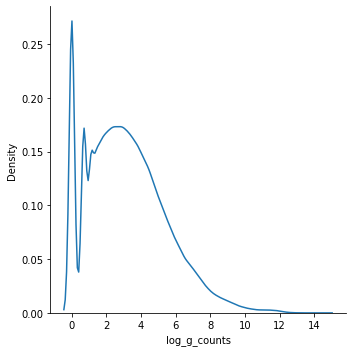

In [7]:
sns.displot(g_df, x='log_g_counts', kind='kde')

In [68]:
e_df = pd.read_csv('241021_entropy_summary.tsv', sep='\t')

In [69]:
e_df.head()

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.191729
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12,0.258531
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14,0.223182
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11,0.200203
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15,0.247052


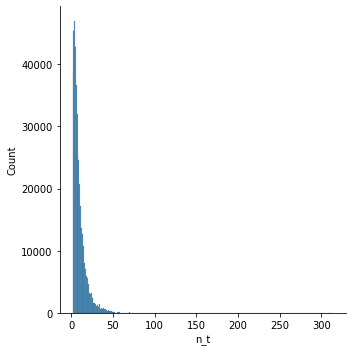

In [10]:
sns.displot(e_df, x='n_t', kind='hist', discrete=True)

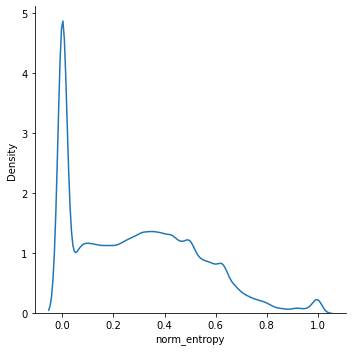

In [11]:
sns.displot(e_df, x='norm_entropy', kind='kde')

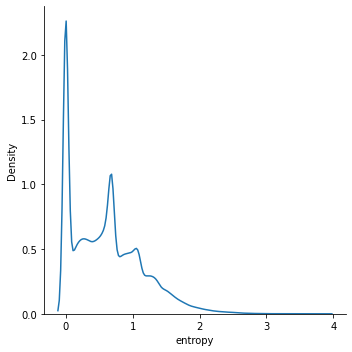

In [12]:
sns.displot(e_df, x='entropy', kind='kde')

In [70]:
# add gene exp
e_df = e_df.merge(g_df, how='left', on=['gid', 'sample', 'population'])
e_df.head()

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy,g_counts,log_g_counts
0,ENSG00000000419.14,AJI1,AJI,24,0.609324,12,0.191729,717.00020,6.576470
1,ENSG00000000419.14,AJI2,AJI,24,0.821625,12,0.258531,689.99997,6.538140
2,ENSG00000000419.14,AJI3,AJI,24,0.709283,14,0.223182,2442.48200,7.801179
3,ENSG00000000419.14,AJI4,AJI,24,0.636257,11,0.200203,370.99948,5.918892
4,ENSG00000000419.14,AJI5,AJI,24,0.785144,15,0.247052,3302.99680,8.102888


## Ok, just highly-expressed NICs

In [6]:
# add struct. cat. 
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
df = df.merge(mt_df[['structural_category', 'isoform']], 
              how='left',
              left_on='tid', 
              right_on='isoform')

In [7]:
temp = df.loc[df.structural_category=='NIC']
temp = temp.loc[temp.population=='YRI']
temp = temp.sort_values(by='t_tpm', ascending=False)

In [8]:
temp.head(10).tail(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,structural_category,isoform
4382842,transcript_153944,ENSG00000112306.8,YRI6,0.163896,3229.810,YRI,174085.567980,8.080488,NIC,transcript_153944
3221986,transcript_153944,ENSG00000112306.8,YRI5,0.139459,2432.840,YRI,152159.234910,7.797226,NIC,transcript_153944
4467982,transcript_368182,ENSG00000164919.11,YRI6,0.926837,2139.690,YRI,20393.995950,7.668883,NIC,transcript_368182
1335595,transcript_153944,ENSG00000112306.8,YRI7,0.121511,1958.880,YRI,217971.011990,7.580639,NIC,transcript_153944
3452233,transcript_368182,ENSG00000164919.11,YRI2,0.909002,1913.750,YRI,34682.005020,7.557342,NIC,transcript_368182
3367093,transcript_153944,ENSG00000112306.8,YRI2,0.059929,1321.030,YRI,363127.954390,7.186924,NIC,transcript_153944
1480702,transcript_153944,ENSG00000112306.8,YRI3,0.085855,1082.630,YRI,138119.544340,6.988072,NIC,transcript_153944
550093,transcript_368182,ENSG00000164919.11,YRI1,0.435643,855.154,YRI,18282.000860,6.752450,NIC,transcript_368182
3439872,transcript_337660,ENSG00000145592.14,YRI2,0.070108,823.507,YRI,193501.769280,6.714786,NIC,transcript_337660
1411311,transcript_345653,ENSG00000234745.14,YRI7,0.366904,812.937,YRI,29957.679311,6.701883,NIC,transcript_345653


In [9]:
temp.loc[temp.tid=='transcript_345653']

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,structural_category,isoform
1411311,transcript_345653,ENSG00000234745.14,YRI7,3.669043e-01,812.937000,YRI,29957.679311,6.701883,NIC,transcript_345653
4458558,transcript_345653,ENSG00000234745.14,YRI6,1.448517e-02,15.717900,YRI,9585.734248,2.816480,NIC,transcript_345653
540669,transcript_345653,ENSG00000234745.14,YRI1,4.210619e-03,9.142090,YRI,20221.326039,2.316694,NIC,transcript_345653
3297702,transcript_345653,ENSG00000234745.14,YRI5,2.876377e-06,0.001089,YRI,3300.950698,0.001088,NIC,transcript_345653
1556418,transcript_345653,ENSG00000234745.14,YRI3,6.768960e-07,0.000544,YRI,8802.002180,0.000544,NIC,transcript_345653
3442809,transcript_345653,ENSG00000234745.14,YRI2,0.000000e+00,0.000000,YRI,7581.980102,0.000000,NIC,transcript_345653


In [39]:
# add novel exon info
nov_e_df = pd.read_csv('241127_exons_novelty_transcript_sample_det.tsv', sep='\t')

# only novel 
nov_e_df = nov_e_df.loc[nov_e_df.novelty == 'Novel']
nov_e_gids = nov_e_df.associated_gene.tolist()
nov_e_tids = nov_e_df.transcript_id.tolist()

In [35]:
# choose some random filts
min_n_t = 5
min_g_counts = 5000
min_entrop = 0.6

temp = e_df.loc[(e_df.n_exp_t>=min_n_t)&\
                (e_df.g_counts>=min_g_counts)&\
                (e_df.norm_entropy>=min_entrop)]

In [37]:
temp.head()

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy,g_counts,log_g_counts
4835,ENSG00000008517.19,AJI5,AJI,75,2.868395,55,0.664367,5381.603510,8.590927
4837,ENSG00000008517.19,CEU1,CEU,75,2.756093,54,0.638356,6227.030140,8.736815
4842,ENSG00000008517.19,HAC1,HAC,75,2.735361,63,0.633554,20952.512270,9.950062
4852,ENSG00000008517.19,ITU5,ITU,75,2.699043,54,0.625142,6756.798689,8.818452
4857,ENSG00000008517.19,LWK5,LWK,75,2.757488,62,0.638679,11698.191750,9.367275


In [43]:
df = df.loc[df.population=='YRI']
df = df.loc[df.tid.isin(nov_e_tids)]

In [45]:
df = df.sort_values(by='t_tpm', ascending=False)

In [52]:
df.head(60).tail(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,isoform,pop_spec_t
6019401,transcript_256831,ENSG00000140379.9,YRI6,0.783219,347.991,YRI,3924.996110,5.855046,transcript_256831,False
4568331,transcript_256831,ENSG00000140379.9,YRI3,0.719667,335.091,YRI,5099.999040,5.817382,transcript_256831,False
4080388,transcript_121773,ENSG00000211677.2_ENSG00000211662.2,YRI1,0.302872,331.257,YRI,10186.266700,5.805909,transcript_121773,False
1811298,transcript_256831,ENSG00000140379.9,YRI5,0.683610,310.986,YRI,3967.920630,5.742958,transcript_256831,False
4527883,transcript_153682,ENSG00000112306.8,YRI3,0.022157,279.401,YRI,138119.544340,5.636221,transcript_153682,False
4586894,transcript_301574,ENSG00000211592.8_ENSG00000239951.1,YRI3,0.890615,259.360,YRI,3189.717220,5.562065,transcript_301574,False
4080387,transcript_121757,ENSG00000211677.2_ENSG00000211662.2,YRI1,0.233264,255.125,YRI,10186.266700,5.545666,transcript_121757,False
4620399,transcript_43887,ENSG00000111669.15,YRI3,0.412236,250.206,YRI,6648.004817,5.526273,transcript_43887,False
847617,transcript_43887,ENSG00000111669.15,YRI7,0.486732,242.630,YRI,6739.990260,5.495651,transcript_43887,False
5966635,transcript_119481,ENSG00000211679.2_ENSG00000211648.2,YRI6,0.943440,218.670,YRI,2047.527400,5.392126,transcript_119481,False


In [56]:
df.loc[df.tid=='transcript_282857']

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm
81349,transcript_282857,ENSG00000105193.9,AJI1,0.021841,193.590,AJI,100001.97237,5.270895
226456,transcript_282857,ENSG00000105193.9,MPC2,0.022137,171.513,MPC,92694.95395,5.150473
371563,transcript_282857,ENSG00000105193.9,CEU3,0.021040,214.366,CEU,101669.00723,5.372339
516670,transcript_282857,ENSG00000105193.9,LWK1,0.018480,208.352,LWK,133475.20707,5.344017
661777,transcript_282857,ENSG00000105193.9,PEL1,0.022694,150.648,PEL,97335.02386,5.021562
806884,transcript_282857,ENSG00000105193.9,YRI7,0.022746,181.170,YRI,107692.96643,5.204940
951991,transcript_282857,ENSG00000105193.9,MPC3,0.018643,148.399,MPC,79916.95025,5.006621
1097098,transcript_282857,ENSG00000105193.9,YRI2,0.021271,201.705,YRI,156208.58713,5.311752
1242205,transcript_282857,ENSG00000105193.9,AJI3,0.020183,109.433,AJI,71009.96056,4.704409
1387312,transcript_282857,ENSG00000105193.9,ITU4,0.020570,113.664,ITU,48207.03191,4.742006


In [57]:
# get the ics cause I dn't see how these are difernet
gtf_df = pr.read_gtf('../data/poder_v1_cds.gtf')

In [59]:
gtf_df = pr.PyRanges(gtf_df)
ic_df = cerberus.get_ic(gtf_df)

In [64]:
tids = ['transcript_282857', 'transcript_282919']
ic_df.loc[ic_df.transcript_id.isin(tids)].ic.tolist()

['39435847-39435705-39435606-39433761-39433664-39433569-39433521-39433418',
 '39435847-39435708-39435606-39433761-39433664-39433569-39433521-39433418']

In [63]:
ic_df.head()

,Chromosome,Strand,transcript_id,gene_id,ic
0,GL000008.2,-,transcript_190114,ENSG00000296775.1,170271-163998-163784-162439
1,GL000008.2,-,transcript_190115,ENSG00000296775.1,170271-164884-164584-163998-163784-162439
2,GL000008.2,-,transcript_190116,ENSG00000296775.1,170271-164884-164602-157581
3,GL000008.2,-,transcript_190117,ENSG00000296775.1,170271-164884-164602-163998-163784-157581
4,GL000008.2,-,transcript_190118,ENSG00000296775.1,170271-164884-164602-163998-163784-162439


In [84]:
tids = ['transcript_222894']
ic_df.loc[ic_df.transcript_id.isin(tids)].ic.tolist()

['65859230-65858342-65858096-65856242-65855934-65855730-65855653-65855448']

## older

In [14]:
# choose some random filts
min_n_t = 5
min_g_counts = 5000
min_entrop = 0.6

temp = e_df.loc[(e_df.n_exp_t>=min_n_t)&\
                (e_df.g_counts>=min_g_counts)&\
                (e_df.norm_entropy>=min_entrop)]

In [15]:
temp.head(20).tail(5)

,gid,sample,population,n_t,entropy,n_exp_t,norm_entropy,g_counts,log_g_counts
341840,ENSG00000196126.12,HAC3,HAC,24,2.004092,14,0.630604,13240.55756,9.491115
341855,ENSG00000196126.12,MPC2,MPC,24,1.972548,11,0.620678,5587.50031,8.628466
341861,ENSG00000196126.12,PEL4,PEL,24,1.984415,13,0.624412,7729.92550,8.952984
341863,ENSG00000196126.12,PEL6,PEL,24,1.992560,12,0.626975,5470.83564,8.607369
347589,ENSG00000197111.16,AJI5,AJI,46,2.644228,32,0.690644,5517.78482,8.615913


In [16]:
gid = 'ENSG00000197111.16'
sample = 'AJI5'
df.loc[(df.gid==gid)&(df['sample']==sample)].sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm
5199754,transcript_41129,ENSG00000197111.16,AJI5,0.199301,63.1876,AJI,5517.78482,4.161810
5199750,transcript_41124,ENSG00000197111.16,AJI5,0.137407,43.5643,AJI,5517.78482,3.796933
5199758,transcript_41135,ENSG00000197111.16,AJI5,0.127108,40.2991,AJI,5517.78482,3.720841
5199746,transcript_41120,ENSG00000197111.16,AJI5,0.118369,37.5284,AJI,5517.78482,3.651396
5199756,transcript_41131,ENSG00000197111.16,AJI5,0.050130,15.8935,AJI,5517.78482,2.826929
5199760,transcript_41137,ENSG00000197111.16,AJI5,0.048933,15.5141,AJI,5517.78482,2.804215
5199795,transcript_41279,ENSG00000197111.16,AJI5,0.039728,12.5956,AJI,5517.78482,2.609746
5199752,transcript_41126,ENSG00000197111.16,AJI5,0.036697,11.6346,AJI,5517.78482,2.536439
5199775,transcript_41202,ENSG00000197111.16,AJI5,0.036005,11.4151,AJI,5517.78482,2.518913
5199755,transcript_41130,ENSG00000197111.16,AJI5,0.032512,10.3078,AJI,5517.78482,2.425493


In [17]:
gid = 'ENSG00000008517.19'
sample = 'AJI5'
df.loc[(df.gid==gid)&(df['sample']==sample)].sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm
5209710,transcript_65780,ENSG00000008517.19,AJI5,0.184285,56.9849,AJI,5381.60351,4.060183
5209730,transcript_65810,ENSG00000008517.19,AJI5,0.135444,41.8822,AJI,5381.60351,3.758457
5209760,transcript_65865,ENSG00000008517.19,AJI5,0.108997,33.7040,AJI,5381.60351,3.546855
5209751,transcript_65848,ENSG00000008517.19,AJI5,0.078527,24.2823,AJI,5381.60351,3.230105
5209763,transcript_65869,ENSG00000008517.19,AJI5,0.066368,20.5225,AJI,5381.60351,3.069099
5209765,transcript_65872,ENSG00000008517.19,AJI5,0.057666,17.8316,AJI,5381.60351,2.935536
5209771,transcript_65881,ENSG00000008517.19,AJI5,0.044962,13.9031,AJI,5381.60351,2.701569
5209721,transcript_65797,ENSG00000008517.19,AJI5,0.039575,12.2373,AJI,5381.60351,2.583039
5209782,transcript_65906,ENSG00000008517.19,AJI5,0.034886,10.7874,AJI,5381.60351,2.467031
5209745,transcript_65840,ENSG00000008517.19,AJI5,0.032961,10.1922,AJI,5381.60351,2.415217


In [18]:
gid = 'ENSG00000205542.11'
sample='CEU4'
df.loc[(df.gid==gid)&(df['sample']==sample)].sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm
1928850,transcript_185237,ENSG00000205542.11,CEU4,0.984280,15534.40000,CEU,178066.225925,9.650877
1928842,transcript_185218,ENSG00000205542.11,CEU4,0.007182,113.35800,CEU,178066.225925,4.739334
1928851,transcript_185239,ENSG00000205542.11,CEU4,0.005390,85.06340,CEU,178066.225925,4.455084
1928848,transcript_185234,ENSG00000205542.11,CEU4,0.001386,21.88000,CEU,178066.225925,3.130263
1928847,transcript_185233,ENSG00000205542.11,CEU4,0.000647,10.20830,CEU,178066.225925,2.416655
1928843,transcript_185225,ENSG00000205542.11,CEU4,0.000295,4.66235,CEU,178066.225925,1.733839
1928836,transcript_185204,ENSG00000205542.11,CEU4,0.000199,3.14084,CEU,178066.225925,1.420899
1928844,transcript_185228,ENSG00000205542.11,CEU4,0.000174,2.74185,CEU,178066.225925,1.319580
1928841,transcript_185216,ENSG00000205542.11,CEU4,0.000165,2.60541,CEU,178066.225925,1.282435
1928849,transcript_185235,ENSG00000205542.11,CEU4,0.000108,1.70428,CEU,178066.225925,0.994836


In [19]:
gid = 'ENSG00000205542.11'
sample='LWK2'
df.loc[(df.gid==gid)&(df['sample']==sample)].sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm
2654385,transcript_185237,ENSG00000205542.11,LWK2,0.785075,7872.54000,LWK,122184.908008,8.971263
2654377,transcript_185218,ENSG00000205542.11,LWK2,0.204594,2051.62000,LWK,122184.908008,7.626872
2654386,transcript_185239,ENSG00000205542.11,LWK2,0.006637,66.54940,LWK,122184.908008,4.212859
2654383,transcript_185234,ENSG00000205542.11,LWK2,0.000922,9.24480,LWK,122184.908008,2.326770
2654382,transcript_185233,ENSG00000205542.11,LWK2,0.000895,8.97522,LWK,122184.908008,2.300104
2654378,transcript_185225,ENSG00000205542.11,LWK2,0.000493,4.94769,LWK,122184.908008,1.783003
2654371,transcript_185204,ENSG00000205542.11,LWK2,0.000375,3.75661,LWK,122184.908008,1.559535
2654384,transcript_185235,ENSG00000205542.11,LWK2,0.000310,3.10656,LWK,122184.908008,1.412586
2654376,transcript_185216,ENSG00000205542.11,LWK2,0.000296,2.97077,LWK,122184.908008,1.378960
2654379,transcript_185228,ENSG00000205542.11,LWK2,0.000215,2.15868,LWK,122184.908008,1.150154


In [20]:
mt_df = pd.read_csv('../data/05_mastertable/master_table.tsv', sep='\t')
mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [21]:
mt_df.structural_category.unique()

array(['FSM', 'ISM', 'NNC', 'Fusion', 'NIC', 'Intergenic', 'Antisense',
       'Genic'], dtype=object)

In [22]:
df = df.merge(mt_df[['isoform', 'pop_spec_t']], 
              how='left', left_on='tid', right_on='isoform')

In [23]:
ps_df = df.loc[(df.pop_spec_t==True)&(df.t_tpm>0)]

In [24]:
ps_df.sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,isoform,pop_spec_t
1928850,transcript_185237,ENSG00000205542.11,CEU4,0.984280,15534.4000,CEU,178066.225925,9.650877,transcript_185237,True
2654385,transcript_185237,ENSG00000205542.11,LWK2,0.785075,7872.5400,LWK,122184.908008,8.971263,transcript_185237,True
3525027,transcript_185237,ENSG00000205542.11,PEL6,0.283456,2694.1200,PEL,74350.825174,7.899198,transcript_185237,True
5531453,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,PEL5,0.882661,162.1430,PEL,4102.162347,5.094627,transcript_121711,True
5121204,transcript_185237,ENSG00000205542.11,AJI5,0.007243,90.7089,AJI,217944.227790,4.518619,transcript_185237,True
4805918,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,HAC6,0.065990,83.9182,HAC,28120.879530,4.441688,transcript_121711,True
767994,transcript_185237,ENSG00000205542.11,YRI7,0.007150,76.0733,YRI,143859.232420,4.344757,transcript_185237,True
4250562,transcript_185237,ENSG00000205542.11,CEU5,0.006399,62.7178,CEU,171148.395200,4.154464,transcript_185237,True
4685883,transcript_185237,ENSG00000205542.11,LWK5,0.006230,57.8203,LWK,133218.236250,4.074487,transcript_185237,True
2073957,transcript_185237,ENSG00000205542.11,HAC1,0.004987,57.1612,HAC,230705.249600,4.063218,transcript_185237,True


In [25]:
ps_df.loc[ps_df.tid!='transcript_185237'].sort_values(by='t_tpm', ascending=False).head(10)

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,isoform,pop_spec_t
5531453,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,PEL5,0.882661,162.1430,PEL,4102.162347,5.094627,transcript_121711,True
4805918,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,HAC6,0.065990,83.9182,HAC,28120.879530,4.441688,transcript_121711,True
4951025,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,PEL4,0.078483,54.5856,PEL,9986.682380,4.017924,transcript_121711,True
798419,transcript_263514,ENSG00000103187.8,YRI7,0.879014,46.0281,YRI,708.000000,3.850745,transcript_263514,True
3499955,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,PEL6,0.323085,42.0320,PEL,1017.696829,3.761944,transcript_121711,True
4225490,transcript_121711,ENSG00000211677.2_ENSG00000211662.2,CEU5,0.949118,36.8762,CEU,678.467590,3.634323,transcript_121711,True
593769,transcript_109376,ENSG00000034510.6,PEL1,0.001757,27.6479,PEL,230741.381750,3.355080,transcript_109376,True
887768,transcript_118713,ENSG00000185651.16,MPC3,0.029893,27.5079,MPC,9239.001630,3.350181,transcript_118713,True
5166459,transcript_298478,ENSG00000134326.12,AJI5,0.995134,23.5007,AJI,411.000000,3.198702,transcript_298478,True
6111620,transcript_118713,ENSG00000185651.16,CEU2,0.023455,22.5681,CEU,11685.028100,3.159894,transcript_118713,True


In [26]:
mt_df.loc[mt_df.isoform=='transcript_185237']

,associated_transcriptid.v,trx_per_asstrx_count_antisense,trx_per_asstrx_count_full-splice_match,trx_per_asstrx_count_fusion,trx_per_asstrx_count_genic,trx_per_asstrx_count_incomplete-splice_match,trx_per_asstrx_count_intergenic,trx_per_asstrx_count_novel_in_catalog,trx_per_asstrx_count_novel_not_in_catalog,associated_geneid.v,...,start,end,strand,discovered_transcripts_per_gene,old_associated_geneid.v,old_associated_gene_biotype,existsFSMinGene,existsFSMinTranscript,filter,pop_spec_t
370254,novel,11799,0,15719,2592,0,7960,53706,126986,ENSG00000205542.11,...,12975985,12977226,+,55,ENSG00000205542.11,protein_coding,True,False,pass,True


In [27]:
ps_df.loc[ps_df.tid=='transcript_185237'].sort_values(by=['population', 't_tpm'])

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,isoform,pop_spec_t
42459,transcript_185237,ENSG00000205542.11,AJI1,0.004556,26.9299,AJI,66693.860850,3.329698,transcript_185237,True
2509278,transcript_185237,ENSG00000205542.11,AJI4,0.005125,29.1614,AJI,50479.860110,3.406563,transcript_185237,True
3960348,transcript_185237,ENSG00000205542.11,AJI2,0.004457,40.0851,AJI,114018.404070,3.715646,transcript_185237,True
1203315,transcript_185237,ENSG00000205542.11,AJI3,0.004588,44.0410,AJI,125701.395100,3.807573,transcript_185237,True
5701632,transcript_185237,ENSG00000205542.11,AJI6,0.005736,49.1456,AJI,149723.278432,3.914931,transcript_185237,True
5121204,transcript_185237,ENSG00000205542.11,AJI5,0.007243,90.7089,AJI,217944.227790,4.518619,transcript_185237,True
1493529,transcript_185237,ENSG00000205542.11,CEU1,0.004581,36.1353,CEU,93595.803030,3.614568,transcript_185237,True
6136953,transcript_185237,ENSG00000205542.11,CEU2,0.004993,37.2335,CEU,90564.893234,3.643712,transcript_185237,True
332673,transcript_185237,ENSG00000205542.11,CEU3,0.004459,40.5797,CEU,90822.845658,3.727612,transcript_185237,True
4250562,transcript_185237,ENSG00000205542.11,CEU5,0.006399,62.7178,CEU,171148.395200,4.154464,transcript_185237,True


In [28]:
gid = 'ENSG00000103187.8'
tid = 'transcript_263514'
sample = 'YRI7'
df.loc[(df.tid==tid)].sort_values(by=['population', 't_tpm'])

,tid,gid,sample,pi,t_tpm,population,g_counts,log_t_tpm,isoform,pop_spec_t
72884,transcript_263514,ENSG00000103187.8,AJI1,0.000000e+00,0.000000e+00,AJI,136.000000,0.000000e+00,transcript_263514,True
2539703,transcript_263514,ENSG00000103187.8,AJI4,0.000000e+00,0.000000e+00,AJI,99.000000,0.000000e+00,transcript_263514,True
3990773,transcript_263514,ENSG00000103187.8,AJI2,3.536738e-09,1.813440e-08,AJI,65.000000,1.813440e-08,transcript_263514,True
5151629,transcript_263514,ENSG00000103187.8,AJI5,3.061228e-02,1.002600e+00,AJI,570.000000,6.944463e-01,transcript_263514,True
1233740,transcript_263514,ENSG00000103187.8,AJI3,3.262411e-01,1.170820e+00,AJI,46.999900,7.751050e-01,transcript_263514,True
5732057,transcript_263514,ENSG00000103187.8,AJI6,3.226788e-01,4.044250e+00,AJI,219.000100,1.618249e+00,transcript_263514,True
1523954,transcript_263514,ENSG00000103187.8,CEU1,0.000000e+00,0.000000e+00,CEU,191.000000,0.000000e+00,transcript_263514,True
6167378,transcript_263514,ENSG00000103187.8,CEU2,0.000000e+00,0.000000e+00,CEU,255.000000,0.000000e+00,transcript_263514,True
1959275,transcript_263514,ENSG00000103187.8,CEU4,4.857713e-07,1.188330e-05,CEU,276.000268,1.188323e-05,transcript_263514,True
363098,transcript_263514,ENSG00000103187.8,CEU3,2.467391e-01,5.687070e+00,CEU,230.000000,1.900176e+00,transcript_263514,True
